In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fuzzywuzzy import fuzz
import os
from scipy.stats import skew, skewtest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [42]:
mockDraft = pd.read_csv('playersDraftStatistics.csv')
projections = pd.read_csv('projections2018.csv').drop('Unnamed: 0',axis=1)

In [43]:
projections['PLAYER']=projections['PLAYER'].apply(lambda x: x.replace('D/ST\xa0D/ST','Defense'))

In [44]:
cityTeam = {'Arizona':'Cardinals', #lookup table to change the city to the team name
           'Atlanta':'Falcons',
           'Baltimore':'Ravens',
           'Carolina':'Panthers',
           'Chicago':'Bears',
           'Cleveland':'Browns',
           'Dallas':'Cowboys',
           'Denver':'Broncos',
           'Green Bay':'Packers',
           'Houston':'Texans',
           'Jacksonville':'Jaguars',
           'Kansas City':'Chiefs',
           'LA Chargers':'Chargers',
           'LA Rams':'Rams',
           'Minnesota':'Vikings',
           'NY Giants': 'Giants',
           'NY Jets': 'Jets',
           'New England':'Patriots',
           'New Orleans': 'Saints',
           'Oakland': 'Raiders',
           'Philadelphia': 'Eagles',
           'Pittsburgh': 'Steelers',
           'San Francisco': '49ers',
           'Tennessee': 'Titans'}

def manualFixDefenseST(data,lookup):
    '''
    Fixes the issue with the D/ST players by changing it to the team name rather than having the city/state name.
    
    Currently uses a very brute force, not efficient pandas approach.
    '''
    dataCopy = data.copy(deep=True)
    for idx,row in dataCopy.iterrows():
        for citystate in lookup:
            if row['PLAYER'].startswith(citystate) and row['PLAYER'].endswith('Defense'):
                dataCopy['PLAYER'].iloc[idx]=dataCopy['PLAYER'].iloc[idx].replace(citystate,lookup[citystate])
    return dataCopy            

In [45]:
mockDraftUpdated=manualFixDefenseST(mockDraft,cityTeam)

C:\Users\ibiyt\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
data=mockDraftUpdated.merge(projections,how='left',on='PLAYER')

In [47]:
nullPlayers=list(data.loc[pd.isnull(data['POS'])]['PLAYER'])

In [48]:
def fixPlayerNames(data,null_list):
    '''
    Uses a list of players from a list of null'''
    importantChars = ['Jr.','.','V','III','II',"'"]
    dataCopy = data.copy(deep=True)
    for idx,player in dataCopy.iterrows():
        for np in null_list:
            if fuzz.partial_ratio(player['PLAYER'],np)>90:
                if any([x for x in importantChars if x in player['PLAYER']]):
                    dataCopy['PLAYER'].iloc[idx]=player['PLAYER']
                else:
                    dataCopy['PLAYER'].iloc[idx]=np
    return dataCopy

projectionsFixed=fixPlayerNames(projections,nullPlayers)

C:\Users\ibiyt\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [49]:
data=mockDraftUpdated.merge(projectionsFixed,how='left',on='PLAYER')

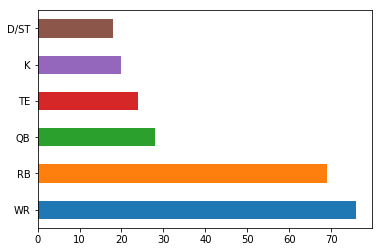

In [50]:
data['POS'].value_counts().plot(kind='barh')

120.0

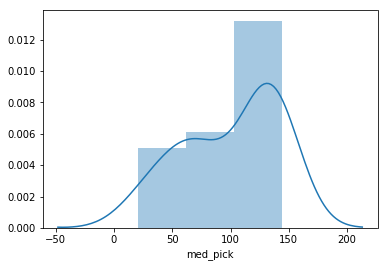

In [51]:
sns.distplot(data.loc[(data['POS']=='TE')]['med_pick'])

data.loc[(data['POS']=='TE')]['med_pick'].median()

## Number of Draft Analysis

By examining the number of drafts we can investigate which players are popularly picked and not so popularly picked. 

Text(0.5,1,'Distrubtion of number of drafts for all players')

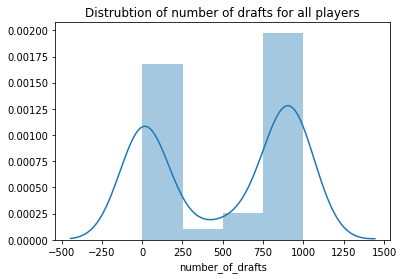

In [52]:
sns.distplot(data['number_of_drafts'])
plt.title('Distrubtion of number of drafts for all players')

The number of drafts is a bimodal distribution with its mean around 500. This is interesting, yet expected behavior as there are a set of players that are not picked often (players that ride the bench or players that are accidently picked even though they are retired.) Then there are popular players that are picked. 

Naively let's choose the mean of 500 to be the threshold for popular and unpopular.

It seems best to just examine the popular players first, but why not look at the unpopular players first. My intuition is we can pick out anomalies from the least popular players, sleepers if you will. This might be important for drafting strategy for later rounds. 

Text(0.5,1,'Distribution of number of drafts for unpopular players')

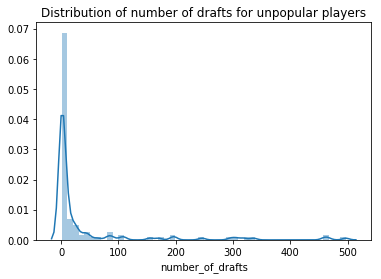

In [53]:
sns.distplot(data['number_of_drafts'].loc[data['number_of_drafts']<500])
plt.title('Distribution of number of drafts for unpopular players')

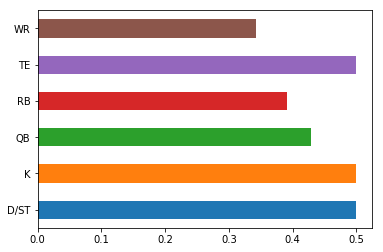

In [54]:
propPOSUnpopular=data.loc[data['number_of_drafts']<500]['POS'].value_counts()/data['POS'].value_counts()
propPOSUnpopular.plot(kind='barh')

It seems as though tight ends, defenses and kickers have a majority of their players in the unpopular positions.

In [55]:
(data.loc[data['number_of_drafts']>=500][['POS','PROJECTION']].groupby('POS').mean() - data.loc[data['number_of_drafts']<500][['POS','PROJECTION']].groupby('POS').mean())/16


,PROJECTION
POS,
D/ST,0.984028
K,0.649375
QB,5.017318
RB,7.774835
TE,4.486458
WR,5.629692


The table above develops the notion that the difference between picking an unpopular kicker vs a popular kicker is about 2 points. The difference is greatest for running backs where the difference is about 7 points. Let's look at the difference between unpopular players and really popular players (>=900 drafts)

In [56]:
(data.loc[data['number_of_drafts']>=900][['POS','PROJECTION']].groupby('POS').mean() - data.loc[data['number_of_drafts']<500][['POS','PROJECTION']].groupby('POS').mean())/16


,PROJECTION
POS,
D/ST,NaN
K,NaN
QB,5.820312
RB,9.799697
TE,4.996875
WR,7.414405


Looking at this data, I want to jump to the conclusion that good running backs are the most scarce. However, I am looking at projections for this year and we all know that projections are not the best tool to look at. We will keep the projections for now.

An interesting question to look at is how well do projections predict performance as a whole.

## Past Performance Analysis

In [57]:
historicalFantasyData=[pd.read_csv(f'HistoricalFantasyData/{data}').fillna(0) for data in os.listdir('HistoricalFantasyData/') if data.endswith('.csv')]
start_year=2010
for data in historicalFantasyData:
    data['YEAR']=start_year
    start_year+=1

In [58]:
def plotsOverTime(all_data,plot=2,scoring='PPR',threshold=500):
    '''
    Uses a set of dataframes and plots histograms/boxplots by either:
    1. Comparing each positions PPR points over time.
    2. Comparing all positions to each other.
    '''
    
    if plot==1:
        combined_data = pd.concat(all_data)
        for pos in set(combined_data['POS']):
            if pos==0:
                continue
            elif scoring=='PPR':
                plt.figure()
                sns.boxplot(data=combined_data.loc[(combined_data['PosRank']<=30) & (combined_data['POS']==pos)],x='YEAR',y='PPR')
                plt.title(pos)
    elif plot==2:
        for year in all_data:
            if scoring=='PPR':
                plt.figure()
                sns.boxplot(data=year.loc[(year['PosRank']<=30) & (year['POS']!=0)],x='POS',y='PPR',order=['TE','RB','WR','QB'])
    elif plot==3:
        combined_data = pd.concat(all_data)
        g = sns.FacetGrid(combined_data.loc[combined_data['PosRank']<=30],col='YEAR',row='POS')
        g.map(plt.hist, "PPR")
    else:
        return 'Invalid plot choice'

C:\Users\ibiyt\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


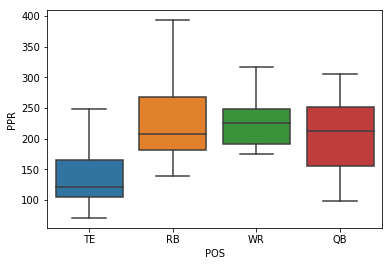

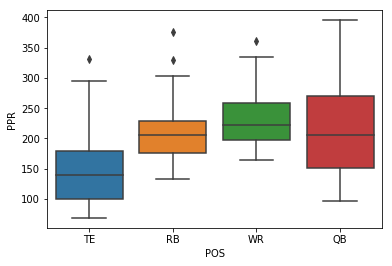

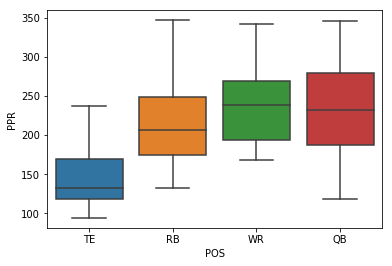

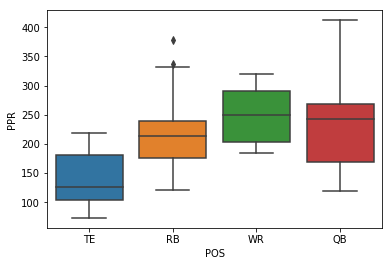

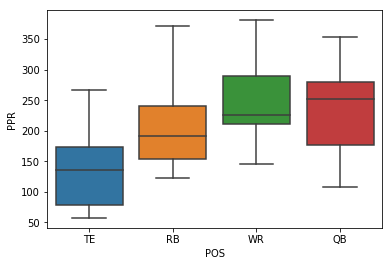

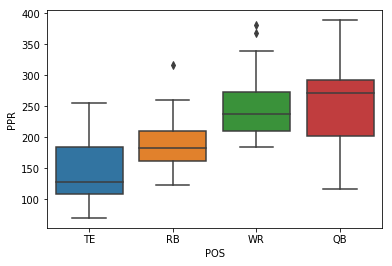

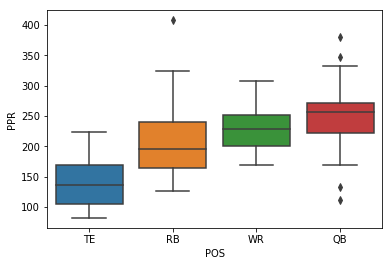

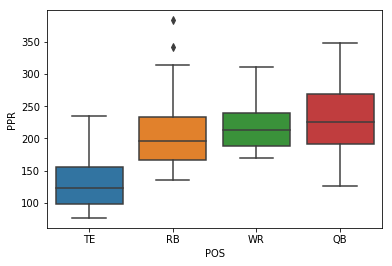

In [59]:
plotsOverTime(historicalFantasyData[:-1])

C:\Users\ibiyt\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


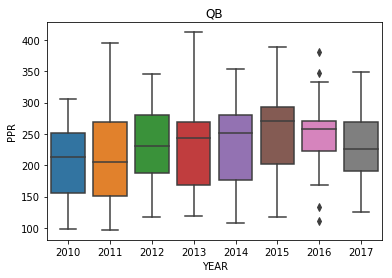

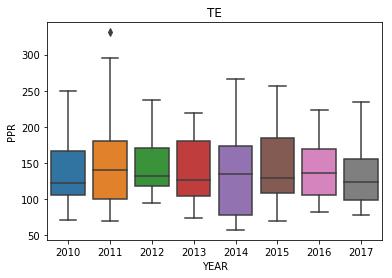

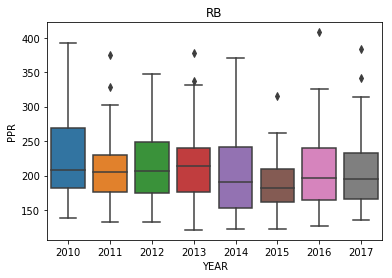

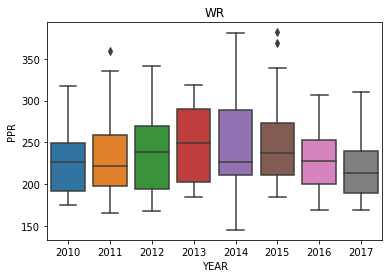

In [60]:
plotsOverTime(historicalFantasyData[:-1],plot=1)

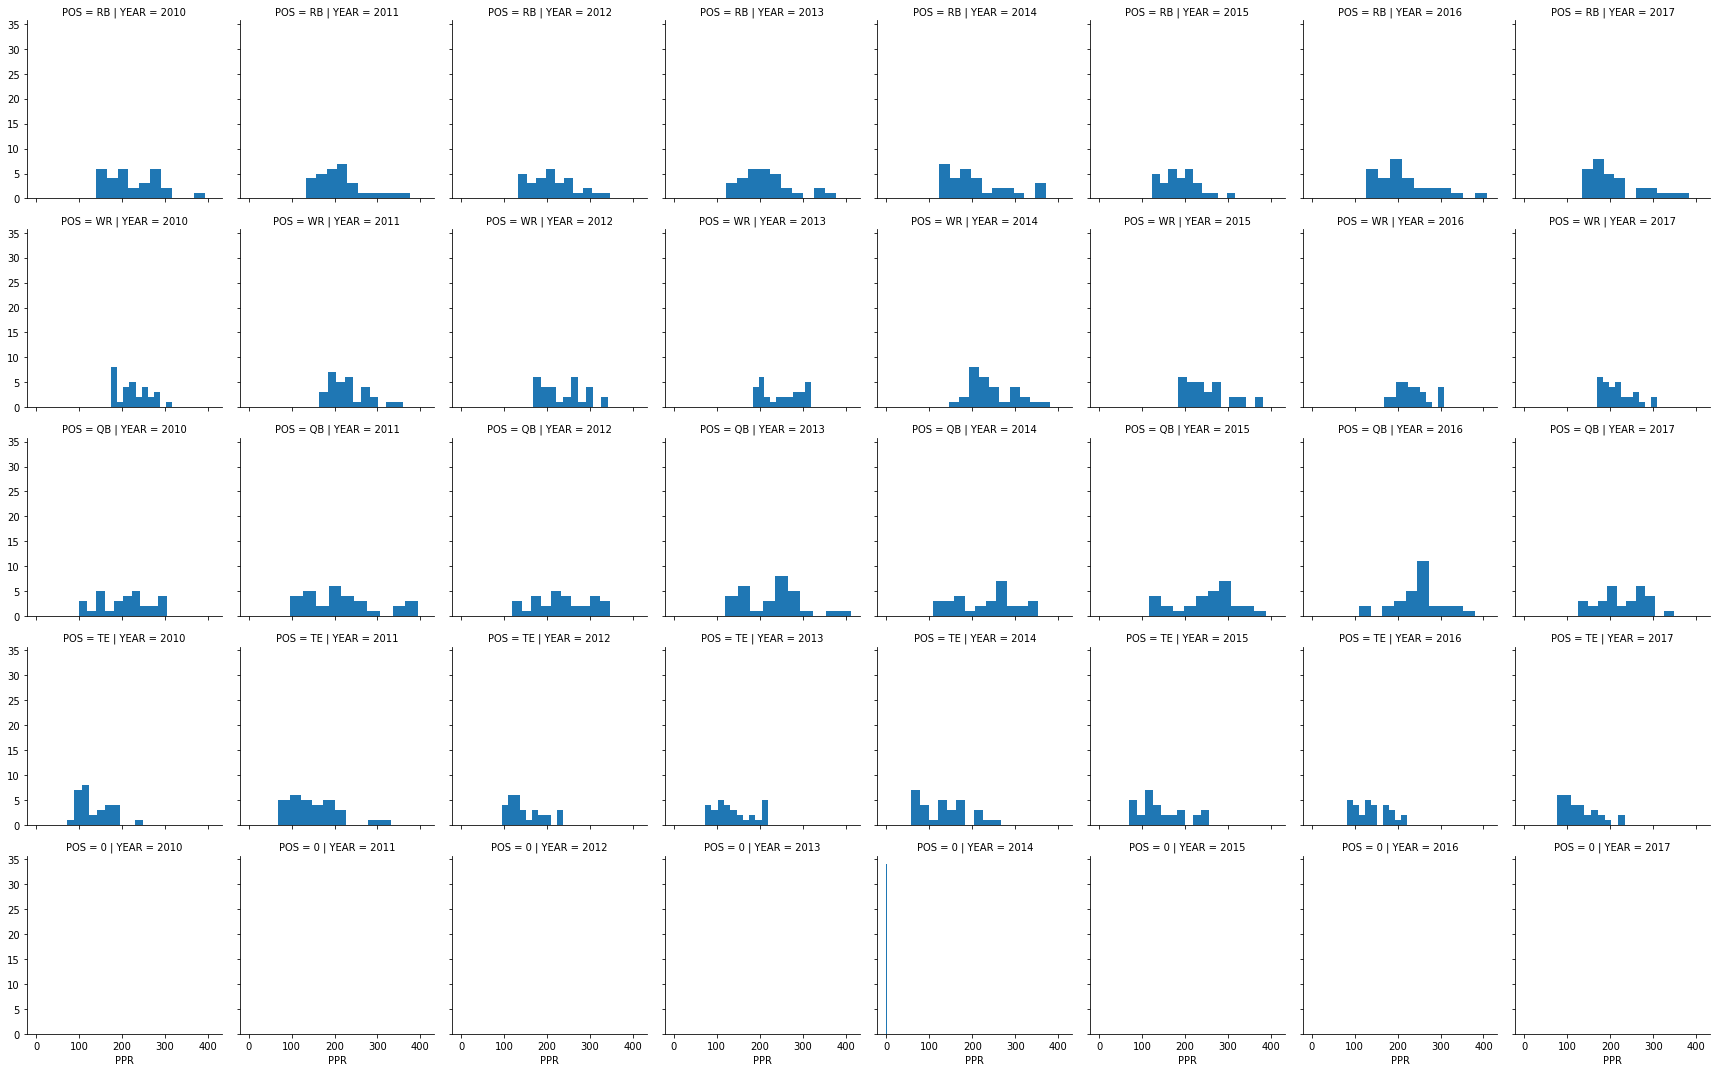

In [61]:
plotsOverTime(historicalFantasyData[:-1],plot=3)

I thought there might be some sort of interesting pattern between ppr points and year (i.e. certain positions showing defined cutoff points for tiers. While our distributions are definitely multimodal, just looking at the position points doesn't seem to be enough to make a solid conclusion. Any patterns I did find simply seem to be the result of me "looking too hard" at the pictures, making something ot of nothing.

In [62]:
def graphSkew(all_data,row,column,scoring='PPR'):
    combined_data = pd.concat(all_data)
    print(combined_data)
    combined_data=combined_data.loc[combined_data['PosRank']<=30]
    rowUnique = [x for x in set(combined_data[row]) if x!=0]
    colUnique = list(set(combined_data[column]))
    print(rowUnique,colUnique)
    skews = [[skew(combined_data[scoring].loc[(combined_data[column]==val) & (combined_data[row]==val2)]) for val in colUnique] for val2 in rowUnique]
    plt.figure()
    for i in range(len(skews)):
        plt.subplot(410+i+1)
        plt.plot(skews[i])
        plt.title(f'{rowUnique[i]} skewtest: {skewtest(skews[i])}')
    

                 PLAYER TEAM POS   AGE    GP    GS  Passing_Cmp  Passing_Att  \
0          Arian Foster  HOU  RB  24.0  16.0  13.0          0.0          0.0   
1         Peyton Hillis  CLE  RB  24.0  16.0  14.0          1.0          2.0   
2       Adrian Peterson  MIN  RB  25.0  15.0  15.0          0.0          0.0   
3        Jamaal Charles  KAN  RB  24.0  16.0   6.0          0.0          0.0   
4         Chris Johnson  TEN  RB  25.0  16.0  16.0          0.0          0.0   
5         Brandon Lloyd  DEN  WR  29.0  16.0  11.0          0.0          0.0   
6           Dwayne Bowe  KAN  WR  26.0  16.0  16.0          0.0          0.0   
7       Darren McFadden  OAK  RB  23.0  13.0  13.0          0.0          1.0   
8           Roddy White  ATL  WR  29.0  16.0  16.0          0.0          0.0   
9          Michael Vick  PHI  QB  30.0  12.0  12.0        233.0        372.0   
10   Rashard Mendenhall  PIT  RB  23.0  16.0  16.0          0.0          0.0   
11         LeSean McCoy  PHI  RB  22.0  

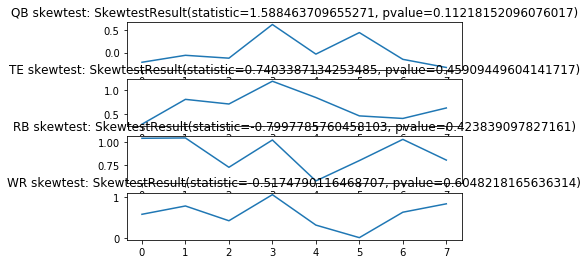

In [63]:
graphSkew(historicalFantasyData[:-1],'POS','YEAR')


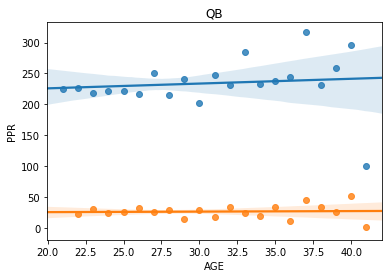

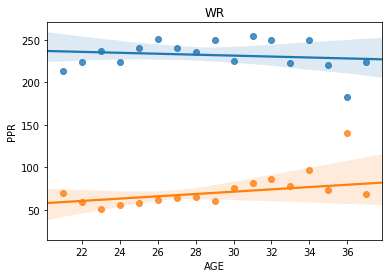

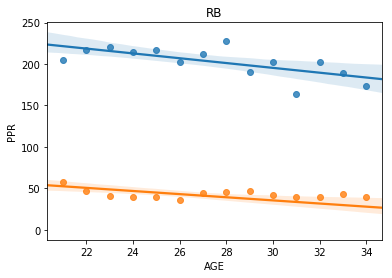

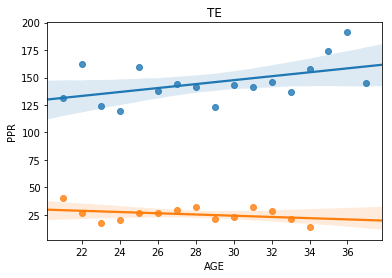

In [64]:
combined_data = pd.concat(historicalFantasyData[:-1])

def plotAge(combined_data,groupby_on=['POS','AGE'],scoring='PPR'):
    combined_data1=combined_data.loc[(combined_data['POS']!=0) & (combined_data['PosRank']<=30)].groupby(groupby_on)[scoring].mean().reset_index()
    combined_data2=combined_data.loc[(combined_data['POS']!=0) & (combined_data['PosRank']>30)].groupby(groupby_on)[scoring].mean().reset_index()
    for pos in set(combined_data1['POS']):
        plt.figure()
        sns.regplot(data=combined_data1.loc[combined_data1['POS']==pos],x='AGE',y='PPR',label='<=30')
        sns.regplot(data=combined_data2.loc[combined_data2['POS']==pos],x='AGE',y='PPR',label='>30')
        plt.title(pos)
plotAge(combined_data)

{'25': 708.0,
 '75': 848.0,
 'max': 1224.0,
 'mean': 779.8113333333333,
 'median': 772.0,
 'min': 519.0}

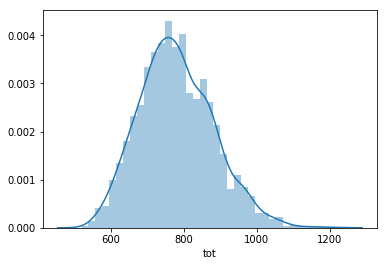

In [71]:
def distributionOfTotalScore(combinedData,year,scoring):
    '''
    Simulates a naive team development and picks players based on the required number of players per position.
    
    1 QB
    2 RB
    2 WR
    1 TE
    1 FLEX
    1 K
    1 DST
    
    Add logic in for no repeats.
    '''
    
    positions = ['QB','RB','WR','TE']
    sampled = combinedData.loc[combinedData['YEAR']==2017]
    roster = {}
    players = []
    for pos in positions:
        player = sampled.loc[(sampled['POS']==pos) & (sampled['PosRank']<=30)].sample(n=1)
        while player['PLAYER'].values[0] in players:
            player = sampled.loc[(sampled['POS']==pos) & (sampled['PosRank']<=30)].sample(n=1)
        players.append(player['PLAYER'].values[0])
        roster[pos]=player[scoring].values[0]

            
    return roster

def simulation(combinedData,year=2017,n_iter=3000,scoring='PPR'):
    sim=pd.DataFrame.from_records([distributionOfTotalScore(combinedData,year,scoring) for i in range(n_iter)])
    sim['tot']=np.sum(sim,axis=1)
    sns.distplot(sim['tot'])
    summary = {'mean':np.mean(sim['tot']),
            'min':min(sim['tot']),
           '25':np.percentile(sim['tot'],25),
           'median':np.percentile(sim['tot'],50),
           '75':np.percentile(sim['tot'],75),
            'max':max(sim['tot'])
           }
    return summary, sim
summary, simulatedData = simulation(combined_data)
summary

In [80]:
len(historicalFantasyData[-2].loc[(historicalFantasyData[-2]['PosRank']<=30) & (historicalFantasyData[-2]['PPR']>=212)]['PPR'])/len(historicalFantasyData[-2].loc[historicalFantasyData[-2]['PosRank']<=30]['PPR'])

0.3120567375886525

This distribution was developed from a naive distribution of team development. Namely, it doesn't take in account factors during the draft such as draft pick and any sort of strategy (pick RB round 1.) It is just a random distribution of picking players as long as you meet the full active roster rules. What we saw for a lot of positions was a dip in performance looking at those distributions over time (the top 30 players did not play as well as the years went on from 2014 with the peak at 2015.) This trend is not as prominent for running backs. 

The best the simulation saw was around 2000, which is definitely very high and the people who drafted around you must have been morons. The 75th percentile was around 1550, which is around what my fantasy score was last year. However, that includes both the results of my kickers and d/st. To make this a complete analysis, I would probably have to explore more on those positions. With the trend I saw with the boxplots, I think its safe to say being the 75th percentile will be good enough to keep me getting money.

Using that as my threshold I want to see what makes sucessful teams. Therefore if you have above 1500, then you are a good team.

In [72]:
simulatedDataClass = simulatedData.copy(deep=True)
simulatedDataClass['GoodTeam'] = [1 if val>=848 else 0 for val in simulatedDataClass['tot']]
simulatedDataClass = simulatedDataClass.drop('tot',axis=1)
simulatedDataClass

,QB,RB,TE,WR,GoodTeam
0,278.0,171.0,117.0,192.0,0
1,296.0,168.0,107.0,223.0,0
2,206.0,145.0,132.0,278.0,0
3,176.0,175.0,143.0,177.0,0
4,263.0,314.0,174.0,278.0,1
5,211.0,175.0,77.0,310.0,0
6,274.0,200.0,77.0,221.0,0
7,126.0,314.0,122.0,240.0,0
8,255.0,158.0,158.0,252.0,0
9,223.0,164.0,202.0,206.0,0


In [100]:
np.random.seed(100)

goodTeam = simulatedDataClass['GoodTeam']
scaler = MinMaxScaler()
input_ = pd.DataFrame(data=scaler.fit_transform(simulatedDataClass.drop('GoodTeam',axis=1)),columns = simulatedDataClass.drop('GoodTeam',axis=1).columns)




X_train, X_test, y_train, y_test = train_test_split(input_,goodTeam)

# search = GridSearchCV(estimator=LogisticRegression(), param_grid={'C':[np.random.rand()*10 if i>0 else 1 for i in range(100)]})
# search.fit(X_train,y_train)

# bestC = search.best_params_['C']

# model = LogisticRegression(C=bestC)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
proba = model.predict(X_test)

print(roc_auc_score(y_score=proba, y_true=y_test))


0.9133064516129032


{'boxes': [<matplotlib.lines.Line2D at 0x1b5518ef278>,
 'caps': [<matplotlib.lines.Line2D at 0x1b5518efc88>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b5518fc940>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1b5518fc518>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1b5518ef3c8>,
  <matplotlib.lines.Line2D at 0x1b551462128>]}

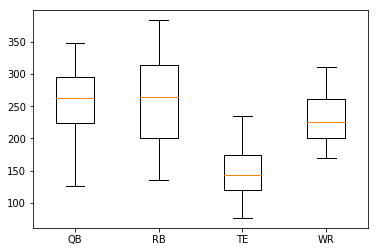

In [98]:
plt.boxplot([simulatedDataClass.loc[simulatedDataClass['GoodTeam']==1]['QB'],simulatedDataClass.loc[simulatedDataClass['GoodTeam']==1]['RB'],simulatedDataClass.loc[simulatedDataClass['GoodTeam']==1]['TE'],simulatedDataClass.loc[simulatedDataClass['GoodTeam']==1]['WR']],labels=['QB','RB','TE','WR'])


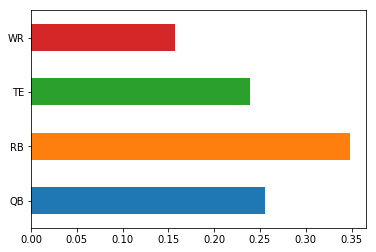

In [102]:
pd.Series(model.feature_importances_,index=X_train.columns).plot(kind='barh')

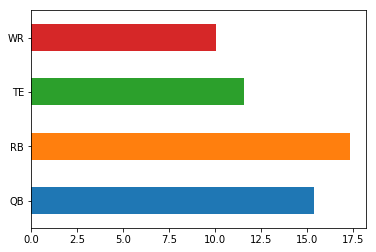

In [85]:
pd.Series(data=model.coef_[0],index=X_train.columns).plot(kind='barh')

So the simulated data told more than what I thought it would. While the discrepancies between importances of WR1 vs. WR2 are random, it seems obvious to state that running backs are the most important pick (they're scarce and they've been known to be valuable. Suprisingly a good tight end also came up higher than wide receivers. 

Clustering algorithms (specifically GMM) have been used to tier players. Instead, let's see if we can cluster positions and get a more defined tier system. If I can tier the 2017 positions, I can see what went into being a good positional player last year. 

In [345]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = silhouette_score(X,kmeans.labels_,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')

In [349]:
combined_data

,PLAYER,TEAM,POS,AGE,GP,GS,Passing_Cmp,Passing_Att,Passing_Yds,Passing_TD,...,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank,YEAR
0,Arian Foster,HOU,RB,24.0,16.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,330.0,393.0,400.5,360.0,192.0,1.0,1.0,2010
1,Peyton Hillis,CLE,RB,24.0,16.0,14.0,1.0,2.0,13.0,0.0,...,0.0,0.0,244.0,297.0,306.9,266.4,106.0,2.0,2.0,2010
2,Adrian Peterson,MIN,RB,25.0,15.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,242.0,277.0,283.4,258.9,104.0,3.0,3.0,2010
3,Jamaal Charles,KAN,RB,24.0,16.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,242.0,284.0,291.0,261.0,103.0,4.0,4.0,2010
4,Chris Johnson,TEN,RB,25.0,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,233.0,274.0,281.4,251.9,95.0,5.0,5.0,2010
5,Brandon Lloyd,DEN,WR,29.0,16.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,209.0,286.0,289.0,247.5,92.0,1.0,6.0,2010
6,Dwayne Bowe,KAN,WR,26.0,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,207.0,278.0,281.1,241.6,89.0,2.0,7.0,2010
7,Darren McFadden,OAK,RB,23.0,13.0,13.0,0.0,1.0,0.0,0.0,...,0.0,0.0,226.0,269.0,277.4,245.9,88.0,6.0,8.0,2010
8,Roddy White,ATL,WR,29.0,16.0,16.0,0.0,0.0,0.0,0.0,...,2.0,0.0,203.0,317.0,320.7,259.7,86.0,3.0,9.0,2010
9,Michael Vick,PHI,QB,30.0,12.0,12.0,233.0,372.0,3018.0,21.0,...,0.0,1.0,316.0,305.0,322.8,311.3,85.0,1.0,10.0,2010


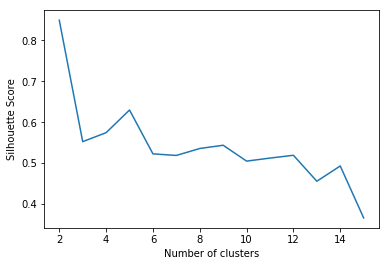

In [352]:
sc_evaluate_clusters(pd.get_dummies(combined_data.loc[combined_data['YEAR']==2017].drop(['PLAYER','FantPt','DKPt','FDPt','VBD'],axis=1)),15)

In [366]:
kmeansAll2017 = KMeans(init='k-means++', n_clusters=5, n_init=10)
data2017 = combined_data.loc[combined_data['YEAR']==2017].drop(['FantPt','DKPt','FDPt','VBD'],axis=1)
clusterData2017 = pd.get_dummies(data2017.drop('PLAYER',axis=1))
labels=kmeansAll2017.fit_predict(clusterData2017)
pd.DataFrame(kmeansAll2017.cluster_centers_.T,index=clusterData2017.columns)

,0,1,2,3,4
AGE,2.875000e+01,2.455882e+01,2.550000e+01,2.674257e+01,2.965385e+01
GP,7.312500e+00,9.600490e+00,1.507500e+01,1.487129e+01,1.523077e+01
GS,6.000000e+00,2.524510e+00,9.875000e+00,1.139604e+01,1.511538e+01
Passing_Cmp,1.291250e+02,1.306373e+00,0.000000e+00,2.970297e-02,3.171154e+02
Passing_Att,2.170000e+02,2.279412e+00,0.000000e+00,8.910891e-02,5.025000e+02
Passing_Yds,1.451250e+03,1.305882e+01,-1.421085e-13,8.118812e-01,3.609231e+03
Passing_TD,7.750000e+00,7.107843e-02,-2.220446e-16,9.900990e-03,2.253846e+01
Int,6.500000e+00,9.068627e-02,6.661338e-16,1.980198e-02,1.103846e+01
Rushing_Att,1.906250e+01,9.176471e+00,1.980750e+02,5.356436e+00,4.711538e+01
Rushing_Yds,9.043750e+01,3.507108e+01,8.191750e+02,2.170297e+01,2.055000e+02


In [372]:
data2017['output']=labels
for i in range(5):
    print(i)
    print(data2017[['PLAYER','TEAM','POS','PPR']].loc[data2017['output']==i])

0
               PLAYER TEAM POS    PPR
94     Deshaun Watson  HOU  QB  169.0
96     Mitch Trubisky  CHI  QB  135.0
97      Aaron Rodgers  GNB  QB  130.0
99     Trevor Siemian  DEN  QB  126.0
101     Brett Hundley  GNB  QB  124.0
120     Carson Palmer  ARI  QB  102.0
134     C.J. Beathard  SFO  QB   89.0
137   Jimmy Garoppolo  SFO  QB   88.0
159  Ryan Fitzpatrick  TAM  QB   74.0
174    Brock Osweiler  DEN  QB   68.0
183       Brian Hoyer  2TM  QB   64.0
191    Blaine Gabbert  ARI  QB   62.0
216        Tom Savage  HOU  QB   51.0
223      Drew Stanton  ARI  QB   50.0
244        Matt Moore  MIA  QB   41.0
280      Mike Glennon  CHI  QB   34.0
1
                PLAYER TEAM POS    PPR
29                   0    0   0    0.0
60                   0    0   0    0.0
79          Alex Armah  CAR   0    0.0
91                   0    0   0    0.0
122                  0    0   0    0.0
124       Rex Burkhead  NWE  RB  130.0
131        Tarik Cohen  CHI  WR  144.0
145         Matt Forte  NYJ  RB  120.0

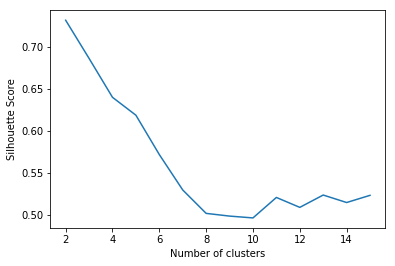

In [373]:
qbData2017 = combined_data.loc[(combined_data['YEAR']==2017) & (combined_data['POS']=='QB')].drop(['FantPt','DKPt','FDPt','VBD'],axis=1)
qbClusterData2017 = pd.get_dummies(qbData2017.drop('PLAYER',axis=1))
sc_evaluate_clusters(qbClusterData2017,15)

In [393]:
def getPosNumClusters(combinedData,pos):
    data2017 = combinedData.loc[(combinedData['YEAR']==2017) & (combinedData['POS']==pos)].drop(['FantPt','DKPt','FDPt','VBD'],axis=1)
    clusterData2017 = pd.get_dummies(data2017.drop('PLAYER',axis=1))
    sc_evaluate_clusters(clusterData2017,15)

def getPosClusterings(combinedData,pos,k):
    data2017 = combinedData.loc[(combinedData['YEAR']==2017) & (combinedData['POS']==pos)].drop(['FantPt','DKPt','FDPt','VBD'],axis=1)
    clusterData2017 = pd.get_dummies(data2017.drop('PLAYER',axis=1))
    kmeansAll2017 = KMeans(init='k-means++', n_clusters=k, n_init=10)
    labels=kmeansAll2017.fit_predict(clusterData2017)
    data2017['output']=labels
    
    print(pd.DataFrame(kmeansAll2017.cluster_centers_.T,index=clusterData2017.columns))
    
    for i in range(k):
        print(f'-----------{i}----------')
        print(data2017[['PLAYER','TEAM','POS','PPR','PosRank']].loc[data2017['output']==i])
    
    return data2017


    

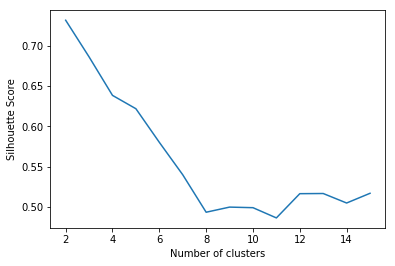

In [376]:
getPosNumClusters(combined_data,'QB')

In [394]:
qb2017=getPosClusterings(combined_data,'QB',4)

                      0             1             2             3
AGE              32.400  2.732258e+01  2.793750e+01  2.875000e+01
GP               15.700  3.096774e+00  1.493750e+01  7.312500e+00
GS               15.700  7.419355e-01  1.475000e+01  6.000000e+00
Passing_Cmp     352.700  1.716129e+01  2.948750e+02  1.291250e+02
Passing_Att     542.200  2.980645e+01  4.776875e+02  2.170000e+02
Passing_Yds    4214.000  1.711935e+02  3.231250e+03  1.451250e+03
Passing_TD       27.500  9.032258e-01  1.943750e+01  7.750000e+00
Int               9.800  1.096774e+00  1.181250e+01  6.500000e+00
Rushing_Att      39.700  3.870968e+00  5.175000e+01  1.906250e+01
Rushing_Yds     149.700  1.077419e+01  2.403750e+02  9.043750e+01
Y/A               2.846  2.468065e+00  4.048750e+00  3.487500e+00
Rushing_TD        1.100  3.225806e-02  2.562500e+00  8.125000e-01
Tgt               0.000  0.000000e+00  0.000000e+00  1.250000e-01
Rec               0.000  0.000000e+00  0.000000e+00  1.250000e-01
Reception_

In [398]:
qb2017['Segment'] = ['Pocket Passers (Top-Tier)' if val==0 else 'Hybrid (Second-Tier)' if val==2 else 'High Int, Young Passers' if val==3 else 'Other QB' for val in qb2017['output']]

Using clustering on past data we see the emergence of really interesting clusters that are mainly tied to tier but there are also some interesting formations going on. There's a passer cluster with names like Matthew Stafford and Matt Ryan in there and a hybrid Cam Newton, Carson Wentz, Marcus Mariota type in another cluster. It seems like the passers are much more lucrative for this game. You want someone like Russel Wilson or Matthew Stafford for drafting a QB

and no stop drafting Derek Carr.

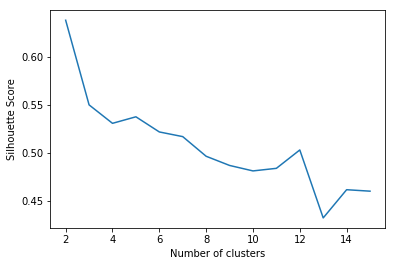

In [382]:
getPosNumClusters(combined_data,'RB')

In [395]:
rb2017=getPosClusterings(combined_data,'RB',5)

                          0             1             2             3  \
AGE            2.450000e+01  2.580247e+01  2.576000e+01  2.527027e+01   
GP             1.500000e+01  9.592593e+00  1.512000e+01  1.259459e+01   
GS             3.250000e+00  1.580247e+00  1.068000e+01  2.648649e+00   
Passing_Cmp    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Passing_Att    8.673617e-19  0.000000e+00  8.673617e-19  2.702703e-02   
Passing_Yds    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Passing_TD     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Int            8.673617e-19  0.000000e+00  8.673617e-19  2.702703e-02   
Rushing_Att    9.562500e+01  1.348148e+01  2.028000e+02  8.305405e+01   
Rushing_Yds    4.112500e+02  4.425926e+01  8.238400e+02  3.292162e+02   
Y/A            4.270000e+00  2.664444e+00  4.082400e+00  4.126757e+00   
Rushing_TD     3.000000e+00  3.456790e-01  5.000000e+00  1.945946e+00   
Tgt            7.887500e+01  7.938272e+00  3.696000

In [409]:
rb2017['Segment'] =['Pass-Catching Back' if val==0 else 'Good Rotational Backs' if val==2 else 'Feature back' if val==4 else 'Other Running Back' for val in rb2017['output']]


We see feature backs in their own cluster, pass catching backs in their own cluster and the large group of other types of backs (I'd assume zeke be in the feature back group but his whole ordeal with the courts definitely dropped his points.)

You want a feature back on your team, which is why you draft them so high, there aren't many to go around clearly.

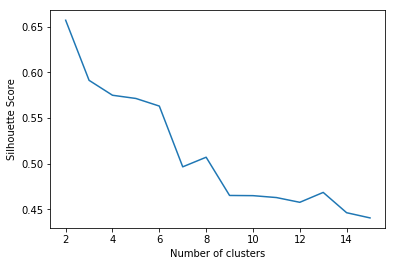

In [384]:
getPosNumClusters(combined_data,'WR')

In [396]:
wr2017=getPosClusterings(combined_data,'WR',6)

                          0             1             2             3  \
AGE            2.657143e+01  2.501099e+01  2.673913e+01  2.687500e+01   
GP             1.403571e+01  9.604396e+00  1.469565e+01  1.550000e+01   
GS             8.678571e+00  1.472527e+00  1.126087e+01  1.487500e+01   
Passing_Cmp    3.469447e-18 -3.122502e-17  8.695652e-02  1.250000e-01   
Passing_Att    3.571429e-02  2.197802e-02  1.304348e-01  2.500000e-01   
Passing_Yds    2.775558e-16  4.440892e-16  2.652174e+00  2.625000e+00   
Passing_TD     1.734723e-18 -1.561251e-17  4.347826e-02  1.734723e-18   
Int            5.204170e-18  2.197802e-02  1.734723e-18  1.250000e-01   
Rushing_Att    1.678571e+00  1.197802e+00  1.956522e+00  2.625000e+00   
Rushing_Yds    8.821429e+00  6.406593e+00  8.217391e+00  1.175000e+01   
Y/A            1.369643e+00  1.703626e+00  2.948696e+00  4.246250e+00   
Rushing_TD    -2.081668e-17  3.296703e-02 -2.081668e-17  0.000000e+00   
Tgt            6.742857e+01  1.108791e+01  9.021739

In [408]:
wr2017['Segment']=['First Tier WR' if val==3 else 'Second Tier WR' if val==2 else 'Other Wide Receiver' for val in wr2017['output']]

There are clear first and second rate wide receivers in clusters 4 and 5. Our algorithm found more in the second group than the first. I drafted two guys in the first group last year, which was pretty great for my team.

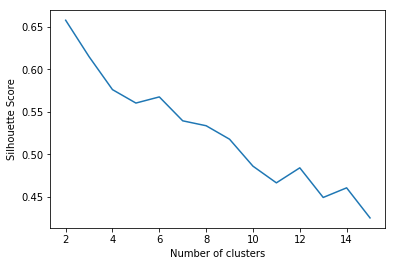

In [386]:
getPosNumClusters(combined_data,'TE')

In [397]:
te2017=getPosClusterings(combined_data,'TE',6)

                          0             1        2             3  \
AGE            2.605882e+01  2.693750e+01    28.00  2.666667e+01   
GP             1.150000e+01  1.487500e+01    15.20  1.330000e+01   
GS             3.617647e+00  1.050000e+01    13.20  7.666667e+00   
Passing_Cmp    0.000000e+00  0.000000e+00     0.00  0.000000e+00   
Passing_Att    2.941176e-02 -3.469447e-18     0.00 -1.387779e-17   
Passing_Yds    0.000000e+00  0.000000e+00     0.00  0.000000e+00   
Passing_TD     0.000000e+00  0.000000e+00     0.00  0.000000e+00   
Int           -6.938894e-18 -1.734723e-18     0.00 -6.938894e-18   
Rushing_Att    1.764706e-01  6.250000e-02     0.60  6.666667e-02   
Rushing_Yds    5.588235e-01  6.250000e-02     2.40  1.666667e-01   
Y/A            2.294118e-01  6.250000e-02     2.60  1.666667e-01   
Rushing_TD    -6.938894e-18 -1.734723e-18     0.20 -6.938894e-18   
Tgt            7.588235e+00  5.112500e+01   106.00  2.610000e+01   
Rec            4.705882e+00  3.168750e+01    69.

In [407]:
te2017['Segment'] = ['God TE' if val==5 else 'Targeted Less TE' if val==4 else 'Targeted More TE' if val==2 else 'Promising TE' if val==1 else 'Other TE' for val in te2017['output']]

Gronk and Kelce are a class of their own.

Groups 1 and 4 are meh back ups.

Groups 0, 2, 3 and 5 (gronk and kelce) are interesting (2 seems to have players that had some promise last season like jenkins and howard.)

Quarterbacks -- There are two really important tiers for qbs. The first is those pocket passer quarterbacks like TB12, Stafford, even Russel Wilson showed up in this group. These are the quarterbacks you want to go after this year. The other group is hybrid quarterbacks like Cam Newton, Tyrod Taylor, etc. So we are ideally looking for those franchise pocket passers.

* It might be good to try and get a hybrid back up qb like tyrod to ride the bench.
* Deshaun Watson was also so fire last year until he got hurt

Running Backs -- There is a stark cluster of those feature backs like LeVeon and Todd Gurley, even Mark Ingram showed up there. I think these might be must grabs in round 1 regardless of what pick you're at cause they're extremely rare and running backs are the most valuable position in this. There is a definitive catch passing back group as well and then another group of good backs that were avaialable last year. More research needs to be done, but I'd think keeping a pass catching RB2 would be more worthwhile.

* You pick at 3, you can get a feature back that'll be really good for this season.

Wide Receivers -- Looking at clusters 4 and 5 it's really simply just first and second tier wide receivers. There is definitely a drop off between tiers but that first tier had some of the best receivers of that season.

Tight Ends -- Gronk and Kelce completely outclass the other tight ends. I'm not sure how Patrick Maholmes affects Kelce or how Gronk holds up this year, but those guys are monsters on their offenses. Looking for players like that is key. A lot of the tiers are interesting but I'd want a flashier tight end this year (group 3.)

* The model we ran on simulated data had TEs rated pretty high after RB. I almost think drafting a TE high might be a good strategy for tomorrow.

A realistic score to have for this season is really 1400-1600. I want to see what type of players show up in a simulation of that.

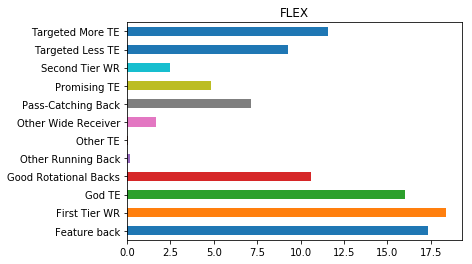

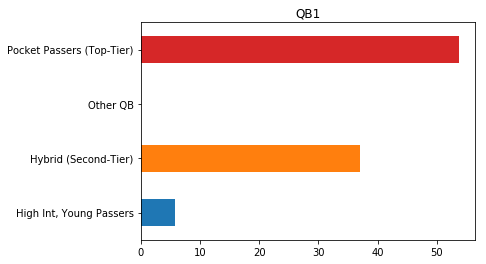

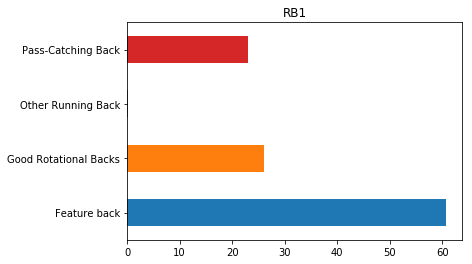

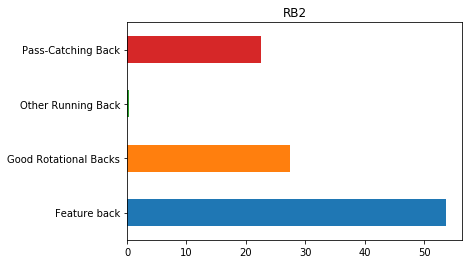

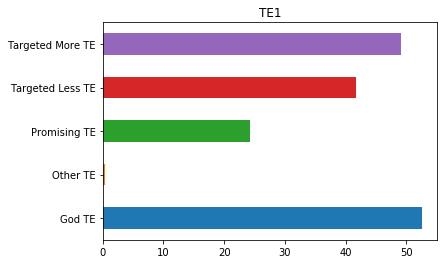

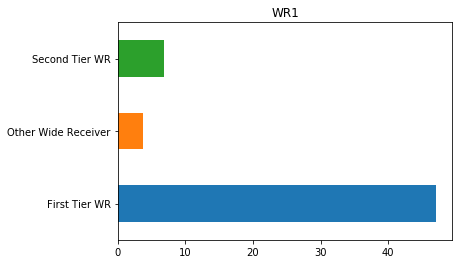

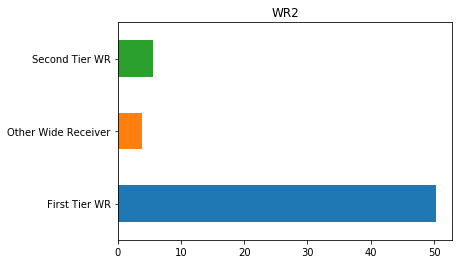

In [422]:
tierList = pd.concat([qb2017,rb2017,wr2017,te2017])

def tierChoice(data):
    '''
    Simulates a naive team development and picks players based on the required number of players per position.
    
    1 QB
    2 RB
    2 WR
    1 TE
    1 FLEX
    1 K
    1 DST
    
    Add logic in for no repeats.
    '''
    
    positions = ['QB1','RB1','RB2','WR1','WR2','TE1','FLEX']
    roster = {}
    players = []
    score = 0
    for pos in positions:
        if pos!='FLEX':
            player = data.loc[(data['POS']==pos[:-1]) & (data['PosRank']<=30)].sample(n=1)
            while player['PLAYER'].values[0] in players:
                player = data.loc[(data['POS']==pos[:-1]) & (data['PosRank']<=30)].sample(n=1)
            players.append(player['PLAYER'].values[0])
            roster[pos]=player['Segment'].values[0]
            score+=player['PPR'].values[0]
        else:
            player = data.loc[(data['PosRank']<=30) & ((data['POS']=='RB') | (data['POS']=='WR') | (data['POS']=='TE'))].sample(n=1)
            while player['PLAYER'].values[0] in players:
                player = data.loc[(data['PosRank']<=30) & ((data['POS']=='RB') | (data['POS']=='WR') | (data['POS']=='TE'))].sample(n=1)
            players.append(player['PLAYER'].values[0])
            roster[pos]=player['Segment'].values[0]
            score+=player['PPR'].values[0]
    roster['score']=score
            
    return roster

def simulation2(data,start_range=1400,end_range=1600,n_iter=3000):
    pool = pd.DataFrame.from_records([tierChoice(data) for i in range(n_iter)])
    pool = pool.loc[(pool['score']>=start_range) & (pool['score']<=end_range)]
    
    for col in pool.columns:
        if col=='score':
            continue
        plt.figure()
        if col != 'FLEX':
            importance = pool[col].value_counts()/data.loc[data['POS']==col[:-1]]['Segment'].value_counts()
        else:
            importance = pool[col].value_counts()/data.loc[(data['POS']=='RB') | (data['POS']=='WR') | (data['POS']=='TE')]['Segment'].value_counts()
        importance.plot(kind='barh')
        plt.title(col)

simulation2(tierList)

The difference between pocket passers and the hybrid isn't much.

The biggest drop off is in the wide receiver category. You have a lot of simulated teams with First Tier WR on their rosters.

Rotational Backs barely beat out pass catching backs for importance. Feature backs dominate

Both God Tier and Targeted More TEs are good. This is good.

Let's use this information and look at picks that will fall to me at 3.

We can look at a strategy looking for the most important position available and the most important type of postional player available. So we rate pocket passers very valuable and other wrs at the least valuable.

**QB**
* Pocket Passer
* Hybrid

**RB**
* Feature back
* Good Rotational back
* Pass Catchers

**TE**
* God tier
* More targets
* Less Targets

**WR**
* First Tier
* Second Tier

These are the types of players we want to target in the draft. The gamble is what role will these players play in 2018.

## Further Analysis on the TE position

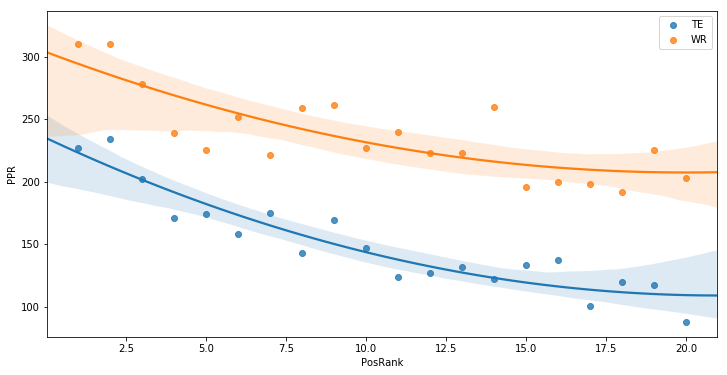

In [38]:
plt.figure(figsize=(12,6))
sns.regplot(data=historicalFantasyData[-2].loc[(historicalFantasyData[-2]['POS']=='TE') & (historicalFantasyData[-2]['PosRank']<=20)][['POS','PosRank','PPR']],x='PosRank',y='PPR',label = 'TE', order=2)
sns.regplot(data=historicalFantasyData[-2].loc[(historicalFantasyData[-2]['POS']=='WR') & (historicalFantasyData[-2]['PosRank']<=20)][['POS','PosRank','PPR']],x='PosRank',y='PPR',label = 'WR', order=2)

plt.legend()


How can we value the tight end position?